# Feedforward Neural Network on the Iris Dataset

We all know about Fisher's Iris Dataset.  

This dataset contains 150 samples, with 4 dimensions, as follows:

1. Petal Length
2. Petal Width
3. Sepal Length
4. Sepal Width

This will be 

In [8]:
%matplotlib inline
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc


import seaborn as sn
import pandas as pd
import random as rd
import datetime as dt

from bigdl.dataset.transformer import *
from bigdl.dataset.base import *
from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from utils import *

from pyspark.sql.functions import col

LABELS = ["Setosa", "Virginica", "Versicolor"]


init_engine()

In [9]:
learning_rate = 0.1
training_epochs = 20
batch_size = 16
display_step = 1

# Network Parameters
n_input = 4
n_classes = 3
n_hidden_1 = 2 # 1st layer number of features


### Sizing the Hidden Layer(s)

Sizing hidden layers can be a challenge.  The best way to figure this out is to do it
empirically.  However, we may need a "rule of thumb" to start.  Here is a good rule of thumb:

First Hidden Layer:
```
n_hidden_1 = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
```

Second Hidden Layer:  (if needed)
```
n_hidden_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
```

In this case, we have a **VERY** simple dataset.  We may not need two hidden layers. Let's see what we have.

In [ ]:
# Number of hidden layers

n_hidden_guess = np.sqrt(np.sqrt((n_classes + 2) * n_input) + 2 * np.sqrt(n_input /(n_classes+2.)))
print("Hidden layer 1 (Guess) : " + str(n_hidden_guess))

n_hidden_guess_2 = n_classes * np.sqrt(n_input / (n_classes + 2.))
print("Hidden layer 2 (Guess) : " + str(n_hidden_guess_2))


In [10]:
iris_training = spark.read.csv("../data/iris/iris_training.csv", header=True, inferSchema="true", mode="DROPMALFORMED")
iris_test = spark.read.csv("../data/iris/iris_test.csv", header=True, inferSchema="true", mode="DROPMALFORMED")

In [11]:
iris_training = iris_training.select([col(c).cast("double") for c in iris_training.columns])
iris_test = iris_test.select([col(c).cast("double") for c in iris_test.columns])



In [12]:
iris_k_train = iris_training.rdd.map(list)
iris_k_test = iris_test.rdd.map(list)

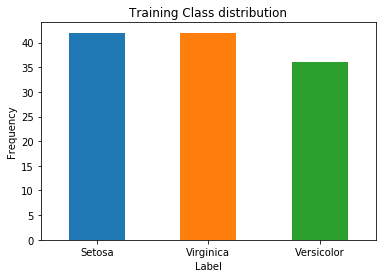

In [13]:
count_classes = pd.value_counts(iris_training.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Training Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

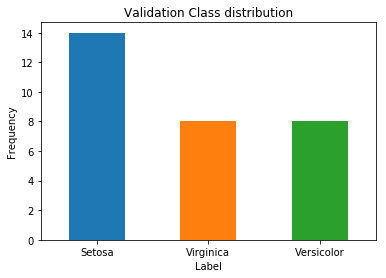

In [14]:
count_classes = pd.value_counts(iris_test.select('label').toPandas()['label'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Validation Class distribution")
plt.xticks(range(n_classes), LABELS)
plt.xlabel("Label")
plt.ylabel("Frequency");

In [15]:
iris_k_train.take(29)

[[6.4, 2.8, 5.6, 2.2, 3.0],
 [5.0, 2.3, 3.3, 1.0, 2.0],
 [4.9, 2.5, 4.5, 1.7, 3.0],
 [4.9, 3.1, 1.5, 0.1, 1.0],
 [5.7, 3.8, 1.7, 0.3, 1.0],
 [4.4, 3.2, 1.3, 0.2, 1.0],
 [5.4, 3.4, 1.5, 0.4, 1.0],
 [6.9, 3.1, 5.1, 2.3, 3.0],
 [6.7, 3.1, 4.4, 1.4, 2.0],
 [5.1, 3.7, 1.5, 0.4, 1.0],
 [5.2, 2.7, 3.9, 1.4, 2.0],
 [6.9, 3.1, 4.9, 1.5, 2.0],
 [5.8, 4.0, 1.2, 0.2, 1.0],
 [5.4, 3.9, 1.7, 0.4, 1.0],
 [7.7, 3.8, 6.7, 2.2, 3.0],
 [6.3, 3.3, 4.7, 1.6, 2.0],
 [6.8, 3.2, 5.9, 2.3, 3.0],
 [7.6, 3.0, 6.6, 2.1, 3.0],
 [6.4, 3.2, 5.3, 2.3, 3.0],
 [5.7, 4.4, 1.5, 0.4, 1.0],
 [6.7, 3.3, 5.7, 2.1, 3.0],
 [6.4, 2.8, 5.6, 2.1, 3.0],
 [5.4, 3.9, 1.3, 0.4, 1.0],
 [6.1, 2.6, 5.6, 1.4, 3.0],
 [7.2, 3.0, 5.8, 1.6, 3.0],
 [5.2, 3.5, 1.5, 0.2, 1.0],
 [5.8, 2.6, 4.0, 1.2, 2.0],
 [5.9, 3.0, 5.1, 1.8, 3.0],
 [5.4, 3.0, 4.5, 1.5, 2.0]]

In [16]:
#convert ndarray data into RDD[Sample]
def array2rdd(ds):
    #build Sample from ndarrays
    def build_sample(c0,c1,c2,c3,prediction):
        feature = np.array([c0,c1, c2, c3]).flatten()
        label = np.array(prediction)
        return Sample.from_ndarray(feature, label)
    rdd = ds.map(lambda (c0,c1,c2,c3,prediction): build_sample(c0,c1,c2,c3,prediction))
    return rdd

iris_rdd_train = array2rdd(iris_k_train)
iris_rdd_train.cache()
print("Training Count: " + str(iris_rdd_train.count()))

iris_rdd_test = array2rdd(iris_k_test)
iris_rdd_test.cache()
print ("Test Count: " + str(iris_rdd_test.count()))

Training Count: 120
Test Count: 30


In [17]:
# Create model

def multilayer_perceptron(n_hidden_1, n_input, n_classes):
    # Initialize a sequential container
    model = Sequential()
    # Hidden layer with ReLu activation
    model.add(Linear(n_input, n_hidden_1).set_name('mlp_fc1'))
    model.add(ReLU())
    # output layer
    model.add(Linear(n_hidden_1, n_classes).set_name('mlp_fc4'))
    model.add(LogSoftMax())
    return model

model = multilayer_perceptron(n_hidden_1, n_input, n_classes)

creating: createSequential
creating: createLinear
creating: createReLU
creating: createLinear
creating: createLogSoftMax


In [18]:
# Create an Optimizer
optimizer = Optimizer(
    model=model,
    training_rdd=iris_rdd_train,
    criterion=ClassNLLCriterion(),
    optim_method=Adagrad(learningrate=learning_rate, learningrate_decay=0.0002),
    end_trigger=MaxEpoch(training_epochs),
    batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=iris_rdd_test,
    trigger=EveryEpoch(),
    val_method=[Top1Accuracy()]
)

app_name='iris-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(50))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print("saving logs to ",app_name)

creating: createClassNLLCriterion
creating: createAdagrad
creating: createMaxEpoch
creating: createOptimizer
creating: createEveryEpoch
creating: createTop1Accuracy
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
('saving logs to ', 'iris-20171114-225053')


In [19]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print("Optimization Done.")

Optimization Done.
CPU times: user 10 ms, sys: 0 ns, total: 10 ms
Wall time: 11.1 s


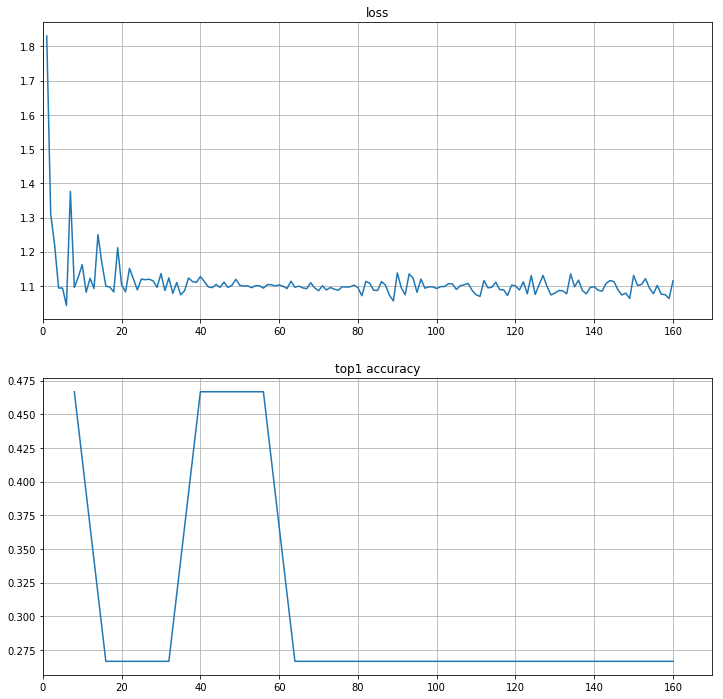

In [20]:
loss = np.array(train_summary.read_scalar("Loss"))
top1 = np.array(val_summary.read_scalar("Top1Accuracy"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")
plt.subplot(2,1,2)
plt.plot(top1[:,0],top1[:,1],label='top1')
plt.xlim(0,loss.shape[0]+10)
plt.title("top1 accuracy")
plt.grid(True)


In [21]:
# TODO: Why don't we see any convergence in the loss function?  
# It just seems to bounce up and down?

In [22]:
predictions = trained_model.predict(iris_rdd_test).collect()

def map_predict_label(l):
    return np.array(l).argmax()
def map_groundtruth_label(l):
    return l.to_ndarray()[0] - 1

y_pred = np.array([ map_predict_label(s) for s in predictions])

y_true = np.array([map_groundtruth_label(s.label) for s in iris_rdd_test.collect()])

The prediction accuracy is 26.67%


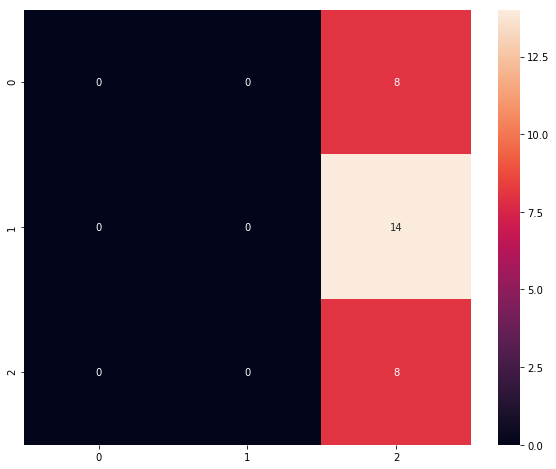

In [23]:
acc = accuracy_score(y_true, y_pred)
print("The prediction accuracy is %.2f%%"%(acc*100))

cm = confusion_matrix(y_true, y_pred)
cm.shape
df_cm = pd.DataFrame(cm)
plt.figure(figsize = (10,8))
sn.heatmap(df_cm, annot=True,fmt='d');

In [24]:
def map_predict_label(outputs, threshold):
    p = map(lambda x: np.exp(x), outputs)
    if (np.max(p) < threshold):
        return len(outputs) + 1
    return np.argmax(outputs) + 1
    

In [25]:
true_positive_rate = list()
false_positive_rate = list()
 
for threshold in np.linspace(0.0, 1.0, num = 100):
    y_pred = np.array([map_predict_label(s, threshold) for s in predictions])
    true_positive_rate.append(calculateTP(y_pred, labels))
    false_positive_rate.append(calculateFP(y_pred, labels))
 

NameError: name 'calculateTP' is not defined

In [ ]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
! tensorboard --logdir=/tmp/bigdl_summaries